In [1]:
%reload_ext autoreload
%autoreload 2

from util import *
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
NT = 467 #int(sys.argv[1])
NR = 801 #int(sys.argv[2])

In [3]:
model_vp, xx, zz = readin_bin(r"Data/Models/model_vp_52.bin", seek_num=0, nt=NT, nr=NR, dx=10, dz=10)
print(model_vp.shape)
print(xx.shape)
print(zz.shape)

(467, 801)
(467, 801)
(467, 801)


In [8]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

#Using GPU
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'


In [9]:
# Configure model presets
from examples.seismic import demo_model, Model

# Enable model presets here:
preset = 'custom'  # A simple but cheap model (recommended)
# preset = 'marmousi2d-isotropic'  # A larger more realistic model

# Standard preset with a simple two-layer model
if preset == 'layers-isotropic':
    def create_model(grid=None):
        return demo_model('layers-isotropic', origin=(0., 0.), shape=(101, 101),
                          spacing=(10., 10.), nbl=20, grid=grid, nlayers=2)
    filter_sigma = (1, 1)
    nshots = 21
    nreceivers = 101
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)


# A more computationally demanding preset based on the 2D Marmousi model
if preset == 'marmousi2d-isotropic':
    def create_model(grid=None):
        return demo_model('marmousi2d-isotropic', data_path='../../../../data/',
                          grid=grid, nbl=20)
    filter_sigma = (6, 6)
    nshots = 301  # Need good covergae in shots, one every two grid points
    nreceivers = 601  # One recevier every grid point
    t0 = 0.
    tn = 3500.  # Simulation last 3.5 second (3500 ms)
    f0 = 0.025  # Source peak frequency is 25Hz (0.025 kHz)

if preset == 'custom':
    def create_model(v, origin, shape, spacing):
        return Model(vp=v, origin=origin, shape=shape, spacing=spacing,
                     space_order=4, nbl=80, bcs="damp")
    filter_sigma = (9, 9)
    # nshots = 301  # Need good covergae in shots, one every two grid points
    # nreceivers = 601  # One recevier every grid point
    t0 = 0.
    tn = 3001.
    f0 = 0.015

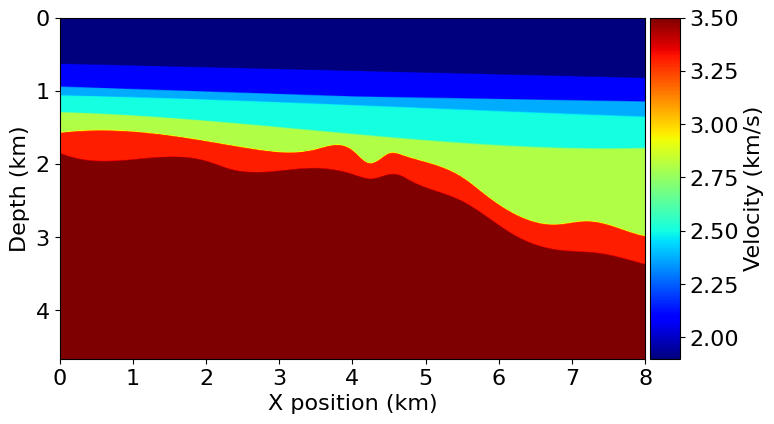

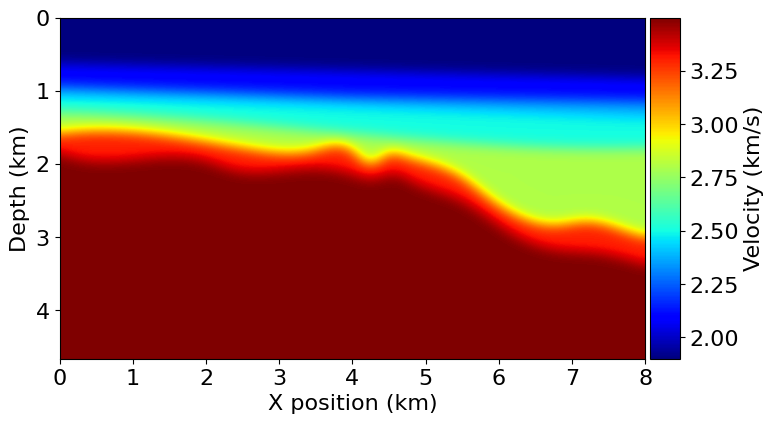

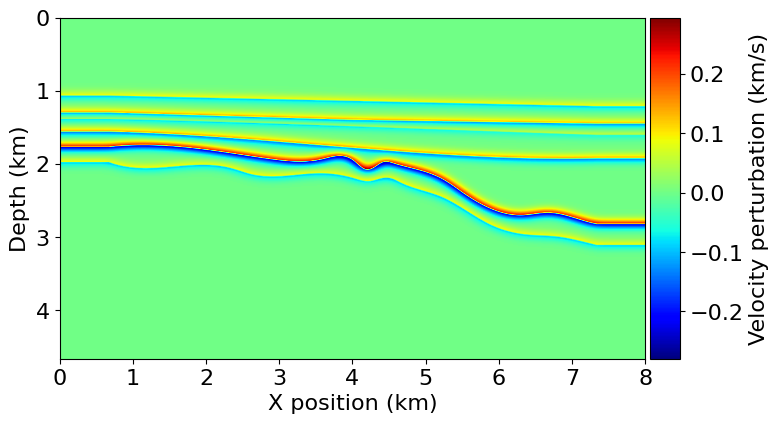

In [10]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_velocity, plot_perturbation
from devito import gaussian_smooth

# Create true model from a preset
model = create_model(v=model_vp.T/1000, origin=(0, 0), shape=model_vp.T.shape, spacing=(10., 10.))

# Create initial model and smooth the boundaries
model0 = create_model(v=model_vp.T/1000, origin=(0, 0), shape=model_vp.T.shape, spacing=(10., 10.))
gaussian_smooth(model0.vp, sigma=filter_sigma)

# Plot the true and initial model and the perturbation between them
plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

In [11]:
import segyio
import numpy as np
from matplotlib import pyplot as plt

In [12]:
path = "Data/R_52.sgy"
src = segyio.open(path, mode='r', endian='big', ignore_geometry=True)
samples = src.samples
data = segyio.tools.collect(src.trace[:])
sou_x = src.attributes(segyio.TraceField.SourceX)[:]
sou_z = src.attributes(segyio.TraceField.SourceSurfaceElevation)[:]
rec_x = src.attributes(segyio.TraceField.GroupX)[:]
rec_z = src.attributes(segyio.TraceField.ReceiverGroupElevation)[:]
src.close()
print(sou_x)
print(sou_z)
print(rec_x)
print(rec_z)

[1100 1100 1100 ... 6900 6900 6900]
[0 0 0 ... 0 0 0]
[4000 4000 4000 ... 4000 4000 4000]
[1000 1010 1020 ... 2230 2240 2250]


In [13]:
nreceivers = np.unique(rec_z).size
nshots = np.unique(sou_x).size

idx = sou_x == np.unique(sou_x)[10]
csg_ensemble = data[idx, :]
csg_rec_z = rec_z[idx]

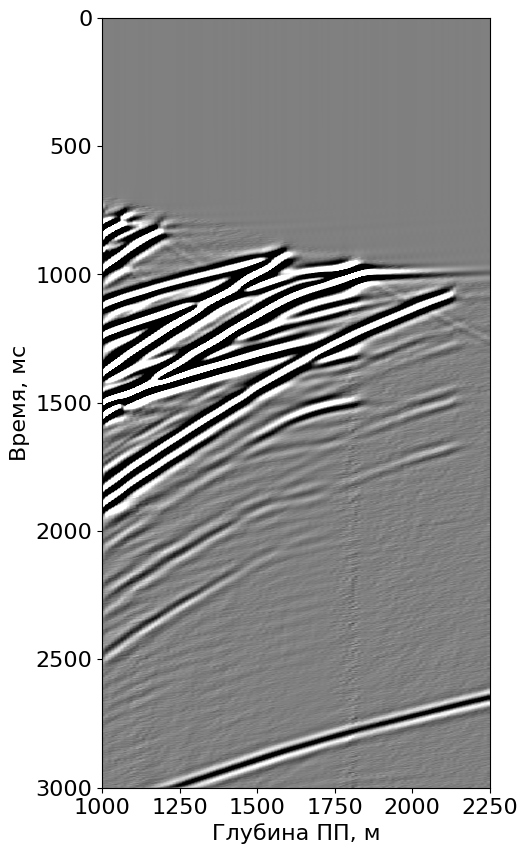

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5, 10))
plt.imshow(csg_ensemble.T, vmin=-np.quantile(csg_ensemble, 0.95), vmax=np.quantile(csg_ensemble, 0.95),
           extent = [csg_rec_z[0], csg_rec_z[-1], samples[-1], samples[0]],
           cmap='gray',
          )
axs.set_xlabel('Глубина ПП, м')
axs.set_ylabel('Время, мс')
axs.set_aspect('auto')
plt.show()

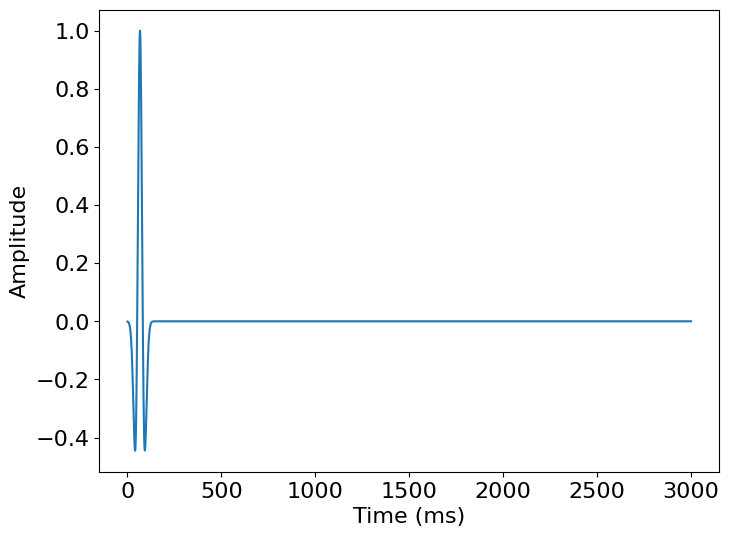

In [15]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.unique(sou_x)[10]
src_coordinates[0, -1] = 0.


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = 4000.
rec_coordinates[:, 1] = csg_rec_z

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

In [16]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d , _, _ = solver.forward(vp=model.vp)

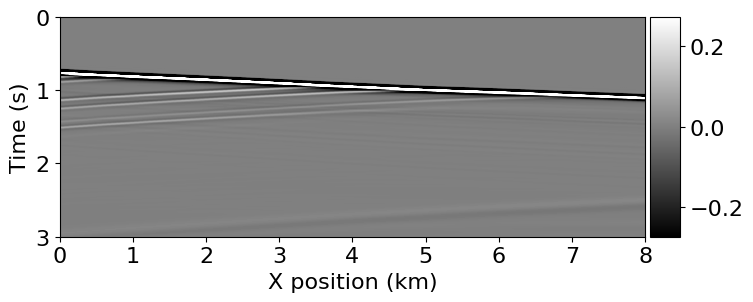

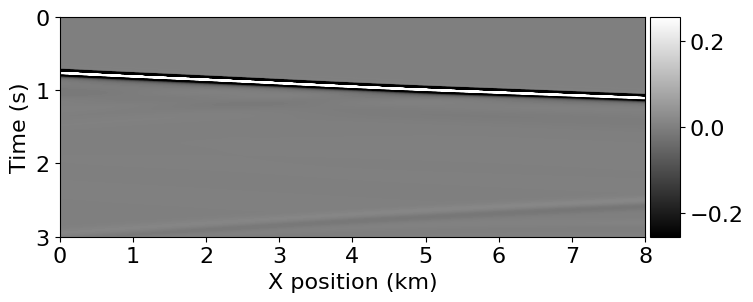

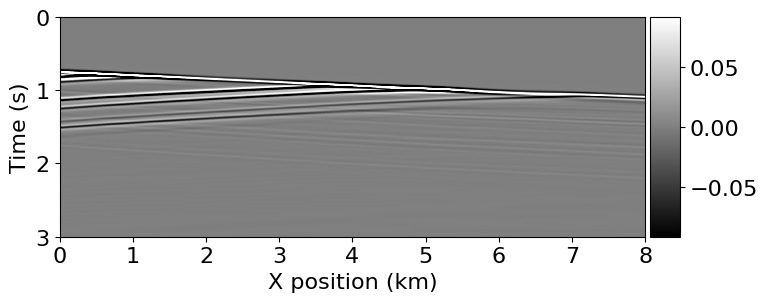

In [19]:
#NBVAL_IGNORE_OUTPUT
# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

In [22]:
# Define gradient operator for imaging
from devito import TimeFunction, Operator, Eq, solve
from examples.seismic import PointSource, TimeAxis, Receiver

def ImagingOperator(model, image):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4,
                     save=geometry.nt)
    
    # Define the wave equation, but with a negated damping term
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T

    # Use `solve` to rearrange the equation into a stencil expression
    stencil = Eq(v.backward, solve(eqn, v.backward))
    
    # Define residual injection at the location of the forward receivers
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - u * v)

    return Operator([stencil] + res_term + [image_update],
                    subs=model.spacing_map)

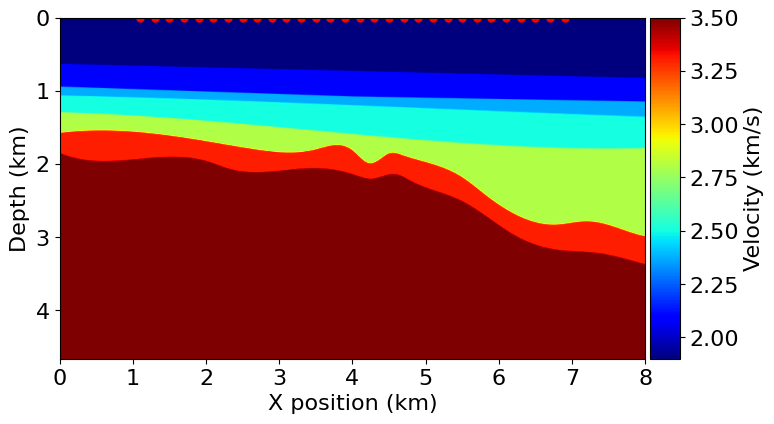

In [23]:
#NBVAL_IGNORE_OUTPUT

# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.unique(sou_x)
source_locations[:, 1] = 0.

plot_velocity(model, source=source_locations)

In [24]:
# Run imaging loop over shots
import gc
from devito import Function, Grid, SparseTimeFunction

# Create image symbol and instantiate the previously defined imaging operator
images = []
image = Function(name='image', grid=model.grid)
op_imaging = ImagingOperator(model, image)

for i in range(1):
    
    print('Imaging source %d out of %d' % (i+1, nshots))
    idx = sou_x == np.unique(sou_x)[i] # В моем скрипте sou_x в одиночку определял ансамбль
    csg_ensemble = data[idx, :]
    csg_rec_z = rec_z[idx]
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]

    # Вызов для модельных данных
    # true_d, _, _ = solver.forward(vp=model.vp)
    
    # Вызов для модельных данных
    # smooth_d, u0, _ = solver.forward(vp=model0.vp, save=True)

    # Вызов для реальных данных - smooth_d не нужен
    _, u0, _ = solver.forward(vp=model0.vp, save=True)
    
    # Compute gradient from the data residual  
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)


    # Receiver нужен чисто для того, чтобы создать объект data.data
    real_data = Receiver(name='rec', grid=model.grid,
               time_range=TimeAxis(start=t0, step=samples[1], num=samples.size), npoint=nreceivers,
               coordinates=rec_coordinates)
    real_data.data[:] = csg_ensemble.T
    real_data = real_data.resample(model.critical_dt)

    # Вызов для реальных данных - резидуал здесь это сразу поле отраженных волн
    op_imaging(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, 
               residual=real_data.data)

    # Вызов для модельных данных
    # op_imaging(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, 
    #            residual=true_d.data-smooth_d.data)


    # Немного поменял исходный скрипт, чтобы можно было смотреть имейджи от отдельных шотов
    images.append(np.array(image.data))
    image.data.fill(0.)
    # del v, real_data, smooth_d, u0
    # del v, u0 # ХЗ работает ли эта фигня
    gc.collect() # Вот эта фигня точно ускоряет процесс

TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory


Imaging source 1 out of 30


TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memo

In [25]:
image.data.shape

(961, 627)

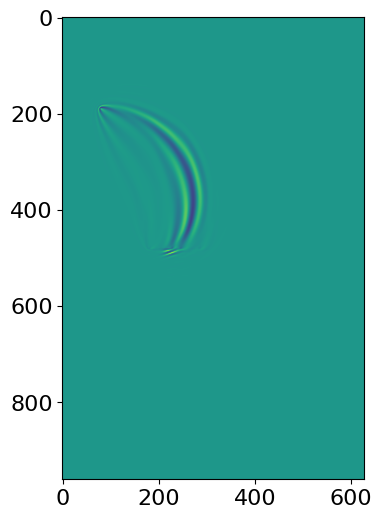

In [26]:
# _, u0, _ = solver.forward(vp=model0.vp, save=True)
plt.imshow(images[0])

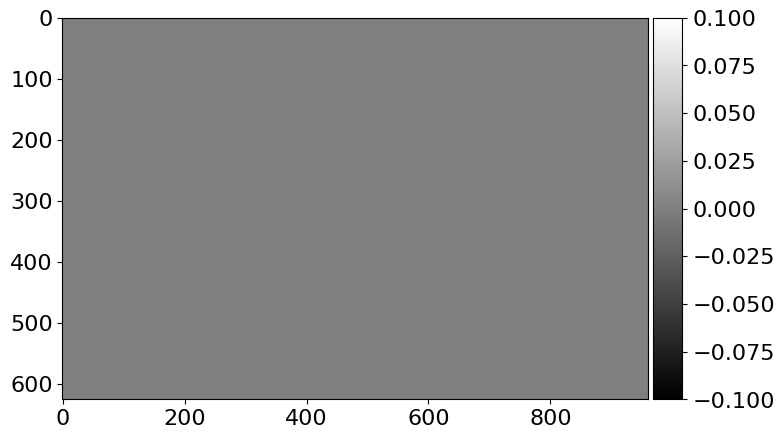

In [27]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_image

# Plot the inverted image
plot_image(np.diff(image.data, axis=1))

In [28]:
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
plot_image(np.diff(images[1], axis=1)[80:-80, 80:-80], xx.T[:, :-1], zz.T[:, :-1], quantile=0.993)

IndexError: list index out of range

<Axes: xlabel='Distance, m', ylabel='Depth, m'>

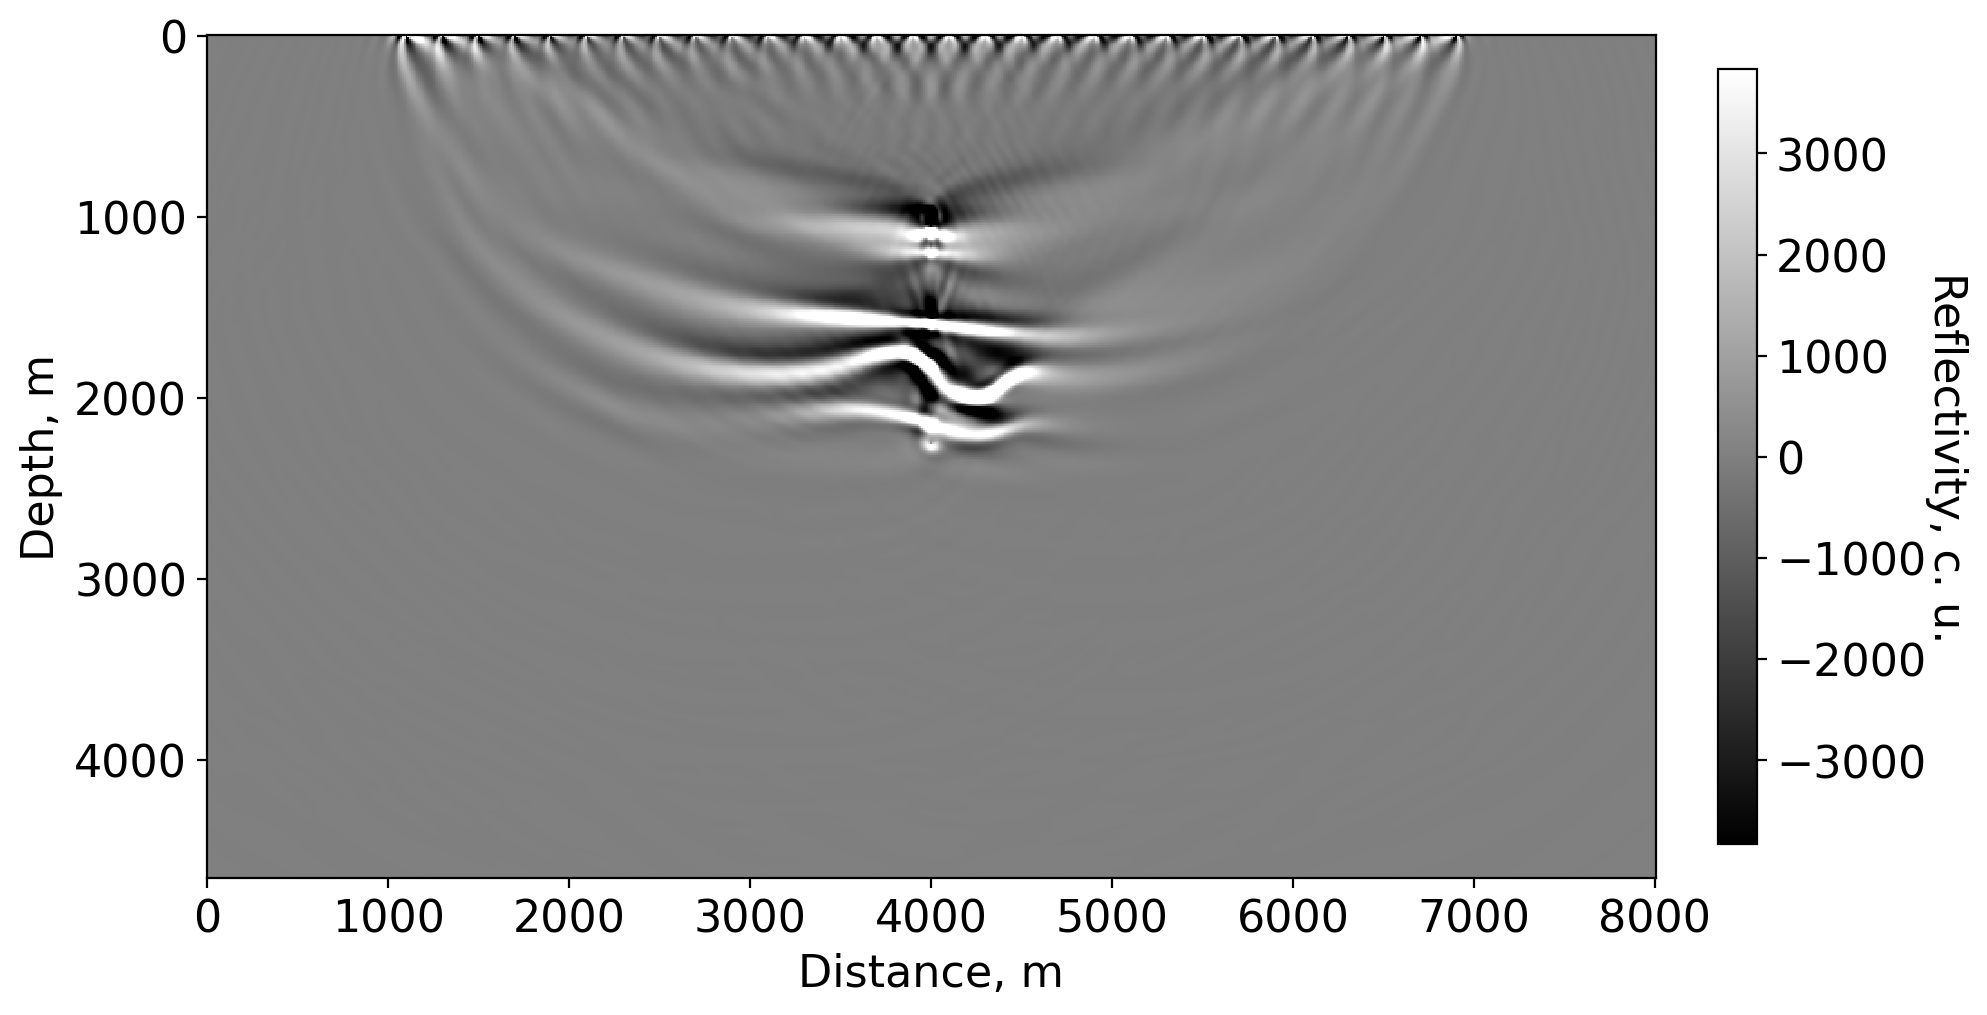

In [32]:
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
stack_image = np.zeros_like(np.diff(images[0], axis=1))
for im in images:
    stack_image += np.diff(im, axis=1)
    # stack_image += im[:, :-1]

# axs = plot_model(np.round(model_vp, -1), xx, zz, rec=None, src=None, show=False)
# axs.pcolormesh(xx.T[:, :-1], zz.T[:, :-1], stack_image[80:-80, 80:-80], alpha=0.7, cmap='gray', vmin=-np.quantile(stack_image[80:-80, 80:-80], 0.995), vmax=np.quantile(stack_image[80:-80, 80:-80], 0.995))
plot_image(stack_image[80:-80, 80:-80], xx.T[:, :-1], zz.T[:, :-1], quantile=0.995, )
# plt.show()

<Axes: xlabel='Distance, m', ylabel='Depth, m'>

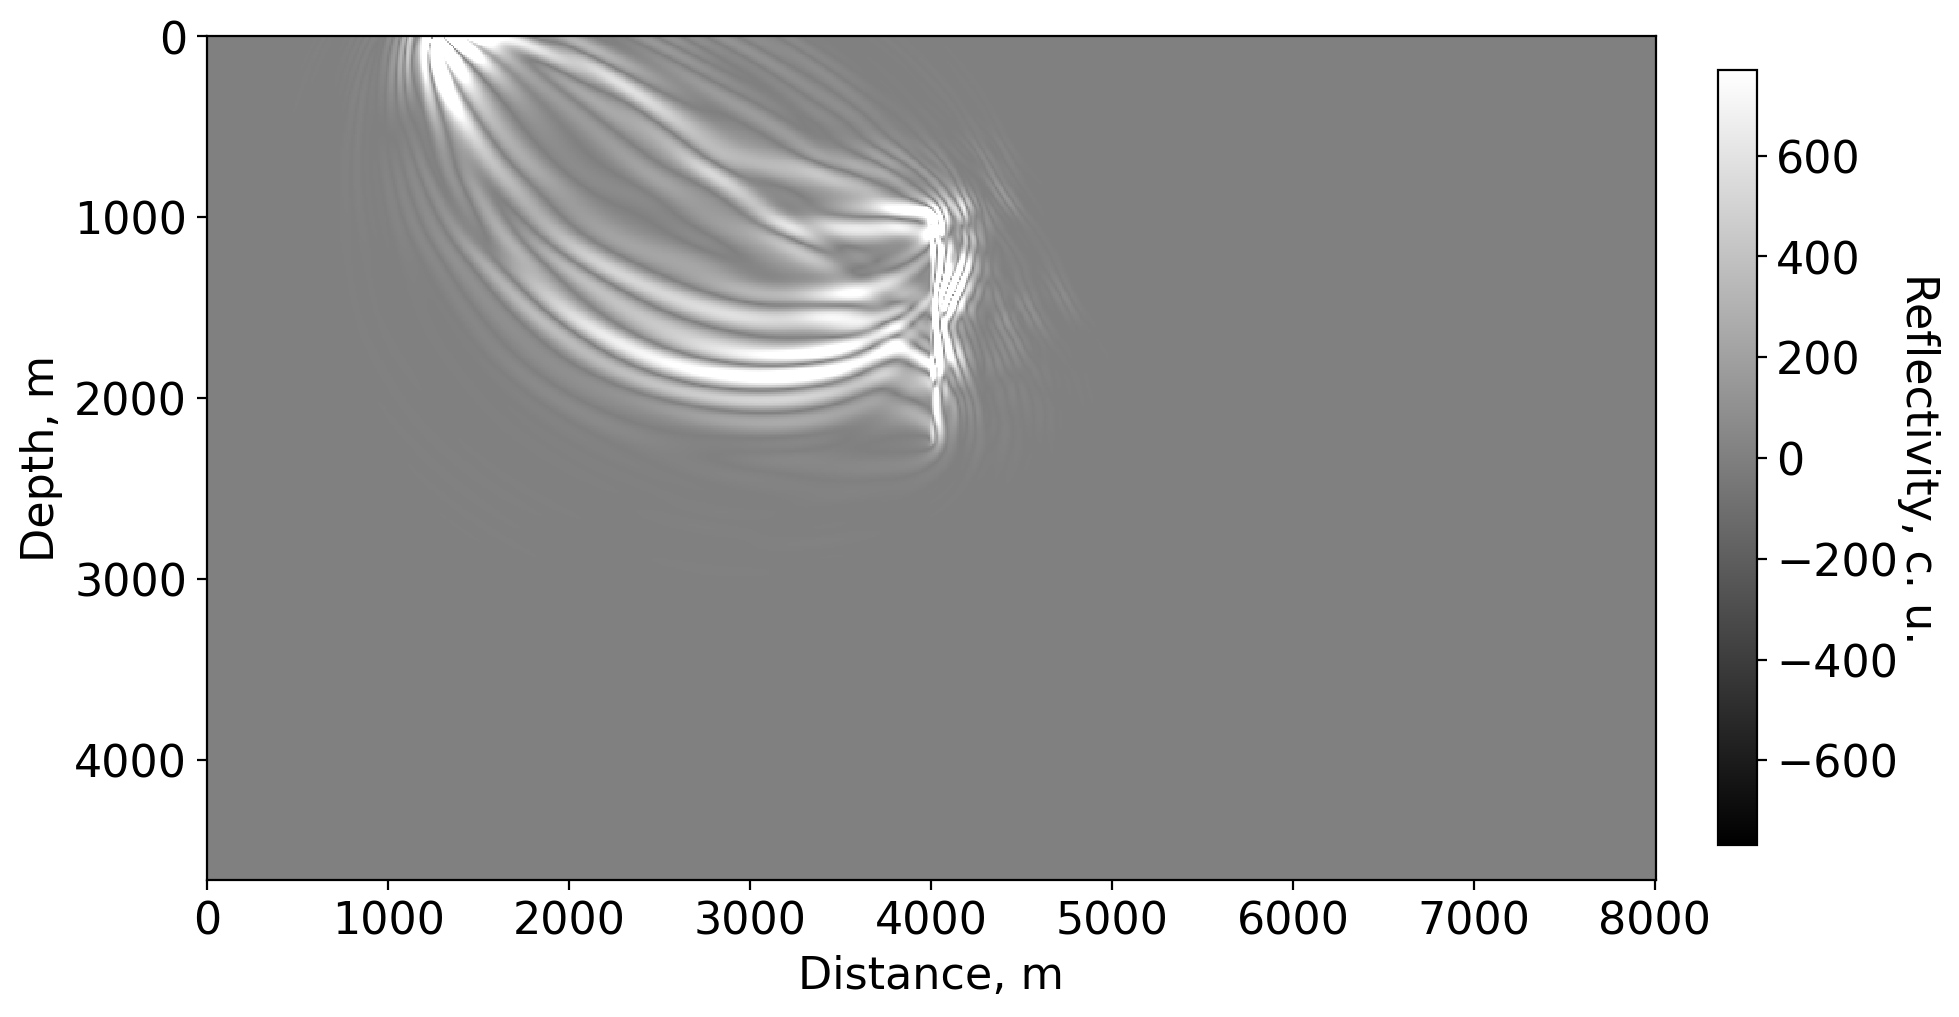

In [25]:
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
buff = np.gradient(images[1])[0]**2 + np.gradient(images[1])[1]**2
plot_image(np.sqrt(buff[80:-80, 80:-80]), xx.T[:, :], zz.T[:, :], quantile=0.993)

In [26]:
# slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
# plot_image(np.array(np.diff(images[5][slices], axis=1)), xx.T[:, :-1], zz.T[:, :-1], quantile=0.9)

And we have an image of the subsurface with a strong reflector at the original location.

## References

[1] _Versteeg, R.J. & Grau, G. (eds.) (1991): The Marmousi experience. Proc. EAGE workshop on Practical Aspects of Seismic Data Inversion (Copenhagen, 1990), Eur. Assoc. Explor. Geophysicists, Zeist._